In [1]:
#!git clone https://github.com/sumitsarkar1/sumitEVA7.git
#%mv sumitEVA7/pytorch_grad_cam/ .

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

In [3]:
import main

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# get the resnet18  model
net = main.getModel()
net = net.to(device)
root_dir = ''

trainloader, testloader = main.prepareData()

/home/sumit/anaconda3/envs/resnet/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [4]:
print("train data set : ",len(trainloader)*100/(len(trainloader) + len(testloader)),"%")
print("test data set : ",len(testloader)*100/(len(trainloader) + len(testloader)),"%")

train data set :  70.0 %
test data set :  30.0 %


In [5]:
from torchsummary import summary
summary(net, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [6]:
torch.cuda.empty_cache()

In [7]:
epochs = 50

max_lr = 0.02
pct_start = 0.3 #10/epochs
steps_per_epoch = len(trainloader)
final_div_factor = 1e4
div_factor = 25

optimizer = main.setOptimizer(net, lr=0.01)
scheduler = main.setScheduler(optimizer, epochs, max_lr, steps_per_epoch, pct_start, div_factor, final_div_factor)

torch.cuda.empty_cache()

lr_variation = []

for epoch in range(epochs):
    lr_variation.append(optimizer.param_groups[0]['lr'])
    print("EPOCH:", epoch+1, "LR Value: ", lr_variation[-1])
    main.train(net, optimizer, scheduler, trainloader, device)
    main.test(net, testloader, device)

EPOCH: 1 LR Value:  0.0007999999999999986


Loss=3.3141345977783203 Batch_id=1203 Train Accuracy=7.04: 100%|█| 1204/120



Test set: Average loss: 0.0638, Test Accuracy: 4094/33000 (12.41%)

EPOCH: 2 LR Value:  0.001009806181671461


Loss=4.022518634796143 Batch_id=1203 Train Accuracy=15.53: 100%|█| 1204/120



Test set: Average loss: 0.0608, Test Accuracy: 5210/33000 (15.79%)

EPOCH: 3 LR Value:  0.001630054177963445


Loss=2.7902557849884033 Batch_id=1203 Train Accuracy=21.69: 100%|█| 1204/12



Test set: Average loss: 0.0530, Test Accuracy: 7628/33000 (23.12%)

EPOCH: 4 LR Value:  0.0026336331839194073


Loss=3.0864572525024414 Batch_id=1203 Train Accuracy=26.33: 100%|█| 1204/12



Test set: Average loss: 0.0516, Test Accuracy: 8511/33000 (25.79%)

EPOCH: 5 LR Value:  0.003976677141363249


Loss=3.0082011222839355 Batch_id=1203 Train Accuracy=30.46: 100%|█| 1204/12



Test set: Average loss: 0.0488, Test Accuracy: 9356/33000 (28.35%)

EPOCH: 6 LR Value:  0.005600482107684926


Loss=2.616384744644165 Batch_id=1203 Train Accuracy=34.50: 100%|█| 1204/120



Test set: Average loss: 0.0447, Test Accuracy: 10800/33000 (32.73%)

EPOCH: 7 LR Value:  0.007434072182933791


Loss=2.9294545650482178 Batch_id=1203 Train Accuracy=37.74: 100%|█| 1204/12



Test set: Average loss: 0.0421, Test Accuracy: 11936/33000 (36.17%)

EPOCH: 8 LR Value:  0.009397301839518453


Loss=2.5996274948120117 Batch_id=1203 Train Accuracy=41.52: 100%|█| 1204/12



Test set: Average loss: 0.0416, Test Accuracy: 12452/33000 (37.73%)

EPOCH: 9 LR Value:  0.01140435905285721


Loss=3.0497822761535645 Batch_id=1203 Train Accuracy=44.20: 100%|█| 1204/12



Test set: Average loss: 0.0421, Test Accuracy: 12378/33000 (37.51%)

EPOCH: 10 LR Value:  0.013367516112465307


Loss=1.7933018207550049 Batch_id=1203 Train Accuracy=47.15: 100%|█| 1204/12



Test set: Average loss: 0.0372, Test Accuracy: 14356/33000 (43.50%)

EPOCH: 11 LR Value:  0.01520096416694739


Loss=2.384347915649414 Batch_id=1203 Train Accuracy=49.65: 100%|█| 1204/120



Test set: Average loss: 0.0370, Test Accuracy: 14565/33000 (44.14%)

EPOCH: 12 LR Value:  0.016824563896385984


Loss=2.021987199783325 Batch_id=1203 Train Accuracy=52.21: 100%|█| 1204/120



Test set: Average loss: 0.0344, Test Accuracy: 15427/33000 (46.75%)

EPOCH: 13 LR Value:  0.01816734837165685


Loss=1.527092695236206 Batch_id=1203 Train Accuracy=54.83: 100%|█| 1204/120



Test set: Average loss: 0.0362, Test Accuracy: 14875/33000 (45.08%)

EPOCH: 14 LR Value:  0.019170624992017427


Loss=1.4844820499420166 Batch_id=1203 Train Accuracy=56.73: 100%|█| 1204/12



Test set: Average loss: 0.0336, Test Accuracy: 16064/33000 (48.68%)

EPOCH: 15 LR Value:  0.019790540916451445


Loss=2.4961678981781006 Batch_id=1203 Train Accuracy=59.10: 100%|█| 1204/12



Test set: Average loss: 0.0330, Test Accuracy: 16287/33000 (49.35%)

EPOCH: 16 LR Value:  0.019999999972210615


Loss=1.9654109477996826 Batch_id=1203 Train Accuracy=61.39: 100%|█| 1204/12



Test set: Average loss: 0.0337, Test Accuracy: 16351/33000 (49.55%)

EPOCH: 17 LR Value:  0.019959676246281848


Loss=2.6919164657592773 Batch_id=1203 Train Accuracy=63.35: 100%|█| 1204/12



Test set: Average loss: 0.0325, Test Accuracy: 16807/33000 (50.93%)

EPOCH: 18 LR Value:  0.0198391633854693


Loss=3.1475982666015625 Batch_id=1203 Train Accuracy=65.40: 100%|█| 1204/12



Test set: Average loss: 0.0326, Test Accuracy: 16987/33000 (51.48%)

EPOCH: 19 LR Value:  0.019639431688467813


Loss=2.0644595623016357 Batch_id=1203 Train Accuracy=67.61: 100%|█| 1204/12



Test set: Average loss: 0.0332, Test Accuracy: 17052/33000 (51.67%)

EPOCH: 20 LR Value:  0.019362089277461317


Loss=1.8234801292419434 Batch_id=1203 Train Accuracy=69.60: 100%|█| 1204/12



Test set: Average loss: 0.0340, Test Accuracy: 16930/33000 (51.30%)

EPOCH: 21 LR Value:  0.019009369150468528


Loss=2.8037235736846924 Batch_id=1203 Train Accuracy=71.44: 100%|█| 1204/12



Test set: Average loss: 0.0335, Test Accuracy: 17224/33000 (52.19%)

EPOCH: 22 LR Value:  0.018584111202555917


Loss=0.5863944292068481 Batch_id=1203 Train Accuracy=73.55: 100%|█| 1204/12



Test set: Average loss: 0.0336, Test Accuracy: 17560/33000 (53.21%)

EPOCH: 23 LR Value:  0.01808973936067246


Loss=1.488130807876587 Batch_id=1203 Train Accuracy=75.91: 100%|█| 1204/120



Test set: Average loss: 0.0337, Test Accuracy: 17527/33000 (53.11%)

EPOCH: 24 LR Value:  0.017530234016203065


Loss=0.7441226840019226 Batch_id=1203 Train Accuracy=77.28: 100%|█| 1204/12



Test set: Average loss: 0.0337, Test Accuracy: 17542/33000 (53.16%)

EPOCH: 25 LR Value:  0.016910099977197578


Loss=1.8227883577346802 Batch_id=1203 Train Accuracy=79.86: 100%|█| 1204/12



Test set: Average loss: 0.0342, Test Accuracy: 17682/33000 (53.58%)

EPOCH: 26 LR Value:  0.01623433019830517


Loss=1.5041298866271973 Batch_id=1203 Train Accuracy=81.61: 100%|█| 1204/12



Test set: Average loss: 0.0356, Test Accuracy: 17588/33000 (53.30%)

EPOCH: 27 LR Value:  0.015508365580439281


Loss=1.2779179811477661 Batch_id=1203 Train Accuracy=83.40: 100%|█| 1204/12



Test set: Average loss: 0.0359, Test Accuracy: 17847/33000 (54.08%)

EPOCH: 28 LR Value:  0.014738051163842684


Loss=0.7475445866584778 Batch_id=1203 Train Accuracy=85.50: 100%|█| 1204/12



Test set: Average loss: 0.0364, Test Accuracy: 17750/33000 (53.79%)

EPOCH: 29 LR Value:  0.013929589067260275


Loss=2.6991734504699707 Batch_id=1203 Train Accuracy=87.44: 100%|█| 1204/12



Test set: Average loss: 0.0375, Test Accuracy: 17789/33000 (53.91%)

EPOCH: 30 LR Value:  0.013089488552125723


Loss=1.493781328201294 Batch_id=1203 Train Accuracy=88.85: 100%|█| 1204/120



Test set: Average loss: 0.0373, Test Accuracy: 17889/33000 (54.21%)

EPOCH: 31 LR Value:  0.012224513613815784


Loss=1.6238032579421997 Batch_id=1203 Train Accuracy=90.61: 100%|█| 1204/12



Test set: Average loss: 0.0381, Test Accuracy: 17952/33000 (54.40%)

EPOCH: 32 LR Value:  0.011341628521936707


Loss=0.9528794288635254 Batch_id=1203 Train Accuracy=91.91: 100%|█| 1204/12



Test set: Average loss: 0.0375, Test Accuracy: 18089/33000 (54.82%)

EPOCH: 33 LR Value:  0.01044794174812027


Loss=0.18019244074821472 Batch_id=1203 Train Accuracy=93.45: 100%|█| 1204/1



Test set: Average loss: 0.0382, Test Accuracy: 18210/33000 (55.18%)

EPOCH: 34 LR Value:  0.009550648732789931


Loss=1.4158657789230347 Batch_id=1203 Train Accuracy=94.82: 100%|█| 1204/12



Test set: Average loss: 0.0382, Test Accuracy: 18330/33000 (55.55%)

EPOCH: 35 LR Value:  0.008656973951705383


Loss=0.7808071374893188 Batch_id=1203 Train Accuracy=95.78: 100%|█| 1204/12



Test set: Average loss: 0.0384, Test Accuracy: 18331/33000 (55.55%)

EPOCH: 36 LR Value:  0.0077741127487316545


Loss=0.5164927840232849 Batch_id=1203 Train Accuracy=96.67: 100%|█| 1204/12



Test set: Average loss: 0.0390, Test Accuracy: 18448/33000 (55.90%)

EPOCH: 37 LR Value:  0.00690917340316111


Loss=1.0471559762954712 Batch_id=1203 Train Accuracy=97.21: 100%|█| 1204/12



Test set: Average loss: 0.0383, Test Accuracy: 18679/33000 (56.60%)

EPOCH: 38 LR Value:  0.006069119898028185


Loss=0.08034481853246689 Batch_id=1203 Train Accuracy=97.83: 100%|█| 1204/1



Test set: Average loss: 0.0389, Test Accuracy: 18722/33000 (56.73%)

EPOCH: 39 LR Value:  0.005260715850212745


Loss=0.45934560894966125 Batch_id=1203 Train Accuracy=98.44: 100%|█| 1204/1



Test set: Average loss: 0.0386, Test Accuracy: 18816/33000 (57.02%)

EPOCH: 40 LR Value:  0.004490470053773921


Loss=0.8080676794052124 Batch_id=1203 Train Accuracy=98.69: 100%|█| 1204/12



Test set: Average loss: 0.0388, Test Accuracy: 18903/33000 (57.28%)

EPOCH: 41 LR Value:  0.003764584074967442


Loss=0.4778521955013275 Batch_id=1203 Train Accuracy=98.91: 100%|█| 1204/12



Test set: Average loss: 0.0385, Test Accuracy: 18978/33000 (57.51%)

EPOCH: 42 LR Value:  0.0030889023208806195


Loss=0.10566432774066925 Batch_id=1203 Train Accuracy=99.19: 100%|█| 1204/1



Test set: Average loss: 0.0389, Test Accuracy: 18978/33000 (57.51%)

EPOCH: 43 LR Value:  0.002468864983702914


Loss=0.22020238637924194 Batch_id=1203 Train Accuracy=99.33: 100%|█| 1204/1



Test set: Average loss: 0.0388, Test Accuracy: 19034/33000 (57.68%)

EPOCH: 44 LR Value:  0.001909464239497235


Loss=0.579412043094635 Batch_id=1203 Train Accuracy=99.44: 100%|█| 1204/120



Test set: Average loss: 0.0386, Test Accuracy: 18998/33000 (57.57%)

EPOCH: 45 LR Value:  0.0014152040541336158


Loss=0.20324552059173584 Batch_id=1203 Train Accuracy=99.55: 100%|█| 1204/1



Test set: Average loss: 0.0383, Test Accuracy: 19025/33000 (57.65%)

EPOCH: 46 LR Value:  0.0009900639200043195


Loss=0.2739030122756958 Batch_id=1203 Train Accuracy=99.65: 100%|█| 1204/12



Test set: Average loss: 0.0385, Test Accuracy: 19098/33000 (57.87%)

EPOCH: 47 LR Value:  0.0006374668154910062


Loss=0.04947947710752487 Batch_id=1203 Train Accuracy=99.62: 100%|█| 1204/1



Test set: Average loss: 0.0383, Test Accuracy: 19093/33000 (57.86%)

EPOCH: 48 LR Value:  0.0003602516451554769


Loss=0.4188329577445984 Batch_id=1203 Train Accuracy=99.66: 100%|█| 1204/12



Test set: Average loss: 0.0386, Test Accuracy: 19041/33000 (57.70%)

EPOCH: 49 LR Value:  0.00016065038254939196


Loss=0.3622516691684723 Batch_id=1203 Train Accuracy=99.68: 100%|█| 1204/12



Test set: Average loss: 0.0384, Test Accuracy: 19126/33000 (57.96%)

EPOCH: 50 LR Value:  4.0270099675616e-05


Loss=0.38646507263183594 Batch_id=1203 Train Accuracy=99.66: 100%|█| 1204/1



Test set: Average loss: 0.0384, Test Accuracy: 19084/33000 (57.83%)



LR peak at :  184.27551020408163 th epoch


ValueError: x and y must have same first dimension, but have shapes (4900,) and (60200,)

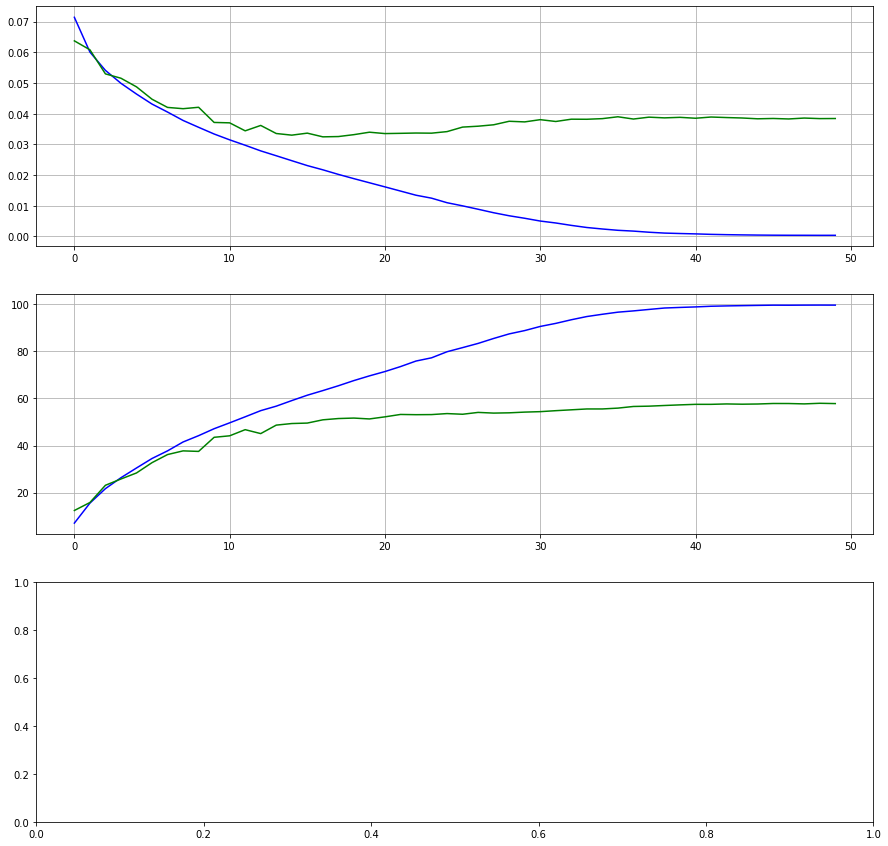

In [9]:
import matplotlib.pyplot as plt

train_losses = main.getTrainLoss()
test_losses = main.getTestLoss()
    
train_acc = main.getTrainAcc()
test_acc = main.getTestAcc()

lr_plot = main.getlrVals()
print("LR peak at : ", lr_plot.index(max(lr_plot))/98, "th epoch")

x_array = []
for x in range(0, epochs*98):
    x_array.append(x/98)
    
fig, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].plot(train_losses, color='b', label='Train Loss')
axs[0].plot(test_losses, color='g', label='Test Loss')
axs[0].grid()
axs[1].plot(train_acc, color='b', label='Train Accuracy')
axs[1].plot(test_acc, color='g', label='Test Accuracy')
axs[1].grid()
axs[2].plot(x_array, lr_plot)
axs[2].grid()
axs[0].legend(loc="upper right")
axs[1].legend(loc="lower right")
axs[0].set_title("Training/Testing Loss")
axs[1].set_title("Training/Testing Accuracy")
axs[2].set_title("One Cycle Learning Rate")

plt.savefig('plot.jpg', bbox_inches='tight')